In [3]:
# Importing packages:
from skimage.segmentation import slic,mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import regionprops
from skimage.color import rgb2hsv
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,KFold,ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
import cv2 as cv 
import os,glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import argparse
imagename= "horse/rgb/horse001.jpg"
labeling= "horse/figure_ground/horse001.jpg"
n_segments =100
sigma = 5 
def preprocessing(imagename, labeling,n_segments,sigma):
    # load the image and convert it to a floating point data type
    image= img_as_float(io.imread(imagename))
    #load the image with the labeling
    imlabels= cv.imread(labeling)
    imlabels= cv.resize(imlabels,(image.shape[1],image.shape[0]))
    # Perform slic super pixels segmentations
    segments = slic(image, n_segments = n_segments, sigma = sigma)
    regionpro=regionprops(segments,imlabels[:,:,1])
    prob=np.array([p.mean_intensity/255 for p in regionpro])
    prob = np.insert(prob, 0, [0])
    labels=[0 if i<0.5 else 1 for i in prob]
    return image,segments,labels

def make3d(descriptor):
    if (descriptor.ndim==2):
        dim=1
    else:
        dim=descriptor.shape[2]
    return np.reshape(descriptor, (descriptor.shape[0],descriptor.shape[1],dim))


def compute_polling(plane, segments):
    numsegments = int(np.max(segments)+1)
    fv = np.zeros((5,numsegments))
    fv[3,:] = np.max(plane)
    fv[4,:] = np.min(plane)
    for y in range(plane.shape[0]):
        for x in range(plane.shape[1]):
            L = int(segments[y,x])
            V = plane[y,x]
            fv[0,L] = fv[0,L]+1
            fv[1,L] = fv[1,L]+V
            fv[2,L] = fv[2,L]+V**2
            fv[3,L] = min(fv[3,L],V)
            fv[4,L] = max(fv[4,L],V)
    #for L in range(numsegments):
    fv[1,:] = fv[1,:]/fv[0,:]
    fv[2,:] = fv[2,:]-fv[1,:]**2
    fv[np.isnan(fv)] = 0
    return fv


def build_features(image, segments):
    hsv = rgb2hsv(image)
    h=hsv[:,:,0]/180
    s=hsv[:,:,1]/255
    v=hsv[:,:,2]/255
    ga=cv.GaussianBlur(image,(61,61),8.0)
    laga=cv.Laplacian(ga,cv.CV_64F)
    sobel= cv.Sobel(image,cv.CV_64F,1,0,ksize=3)
    descriptors=[image,h,s,v,ga,laga,sobel]  
    dataset=np.zeros((5,segments.max()+1))
    count=0
    for descriptor in descriptors:
        descriptor = make3d(descriptor)
        for channel in range(0,descriptor.shape[2]):
            plane = descriptor[:,:,channel]
            fv=compute_polling(plane,segments)
            dataset=np.r_[dataset,fv]
    return dataset

def build_dataset(imagespath,labelingpath):
    imlist = glob.glob(os.path.join(imagespath,'*.jpg'))
    data  = np.ndarray((0,80))
    labeling = []
    for im in imlist[0:20]:
        image,segments,labels = preprocessing(im,labelingpath+im[10:],n_segments,sigma)
        dataset = np.transpose(build_features(image,segments))
        data = np.r_[data,dataset]
        labeling += labels
    return data,labeling

def classify(dataset,labels):
    k = 5
    n_splits=5
    skf = StratifiedKFold(n_splits=n_splits)
    skf_ss = StratifiedShuffleSplit(n_splits=n_splits)
    C=1
    classifiers={"knn":KNeighborsClassifier(n_neighbors=k),"svml":svm.SVC(kernel='linear', C=C)
                 ,"svmr":svm.SVC(kernel='rbf', C=C),
                   "boost":GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                                             max_depth=2, random_state=0)}
    scores={}
    for k in classifiers.keys():
        sc= cross_val_score(classifiers[k],dataset,labels,cv=skf)
        sc2= cross_val_score(classifiers[k],dataset,labels,cv=skf_ss)
        scores[k]=[sc.mean(),sc.std()]
        scores["shuffling "+ k]=[sc2.mean(),sc2.std()]
    return scores
        

# Single Image Example: 

In [ ]:
imagename= "horse/rgb/horse001.jpg"
labeling= "horse/figure_ground/horse001.jpg"
n_segments =100
sigma = 5 
image,segments,labels=preprocessing(imagename,labeling,n_segments,sigma)
dataset=build_features(image,segments)
data=np.transpose(dataset)
classify(data,labels)

# 21 Images Example :

In [ ]:
imagespath = "horse/rgb/"
labelingpath = "horse/figure_ground/"
data,labels = build_dataset(imagespath,labelingpath)

In [ ]:
classify(data,labels)

# Profiler : Timer. 

In [ ]:
from functools import wraps
from time import time
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print ('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap


# Active Learning

In [3]:
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import *
from libact.query_strategies import *
from libact.labelers import IdealLabeler

def run(trn_ds, tst_ds, lbr, model, qs, quota):
    E_in, E_out = [], []

    for i in range(0,quota,1):
        
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)
        
        #print("Step {}: Picked {}".format(i,ask_id))

        model.train(trn_ds)
        
        e_in = 1 - model.score(trn_ds)
        e_out = 1 - model.score(tst_ds)
        
        E_in = np.append(E_in, e_in)
        E_out = np.append(E_out, e_out)
        
        print("Pick {}, error = {:4d} train, {:4d} test".format(i,e_in,e_out))

    return E_in, E_out


def split_train_test(X,y, test_size, n_labeled):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    trn_ds = Dataset(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds
def active_learning(data,labels,test_size,n_labeled):
    # Load dataset
    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = split_train_test(data,labels, test_size, n_labeled)
    trn_ds2 = copy.deepcopy(trn_ds)
    lbr = IdealLabeler(fully_labeled_trn_ds)

    quota = len(y_train) - n_labeled    # number of samples to query

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
    print("Running UncertaintySampling...")
    qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
    model = LogisticRegression()
    E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

    print("Running RandomSampling...")
    qs2 = RandomSampling(trn_ds2)
    model = LogisticRegression()
    E_in_2, E_out_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota)
    
    print("Plotting...")
    
    # Plot the learning curve of UncertaintySampling to RandomSampling
    # The x-axis is the number of queries, and the y-axis is the corresponding
    # error rate.
    query_num = np.arange(1, quota + 1)
    plt.plot(query_num, E_in_1, 'b', label='qs Ein')
    plt.plot(query_num, E_in_2, 'r', label='random Ein')
    plt.plot(query_num, E_out_1, 'g', label='qs Eout')
    plt.plot(query_num, E_out_2, 'k', label='random Eout')
    plt.xlabel('Number of Queries')
    plt.ylabel('Error')
    plt.title('Experiment Result')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
    plt.show()
    
    print("Done")
    
    return (E_in_1,E_in_2,E_out_1,E_out_2)

In [ ]:
def active_learning(data,labels,test_size,n_labeled)

    

# Whole Dataset -

In [4]:
data=np.loadtxt("data.txt")
labels=np.loadtxt("labels.txt")

In [5]:
test_size = 0.25    # the percentage of samples in the dataset that will be
                    # randomly selected and assigned to the test set
n_labeled = 2      # number of samples that are initially labeled

In [24]:
%matplotlib inline
(E_in_1,E_in_2,E_out_1,E_out_2)=active_learning(data,labels,test_size,n_labeled)
print(E_out_1,E_out_2)

Running UncertaintySampling...
Pick 0, error = 0.0 train, 0.22479135312628262 test


/Users/megret/anaconda/envs/bnl/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Pick 1, error = 0.0 train, 0.22383362977151455 test
Pick 2, error = 0.0 train, 0.2283486113011356 test
Pick 3, error = 0.0 train, 0.228622246545355 test
Pick 4, error = 0.0 train, 0.22643316459159935 test
Pick 5, error = 0.0 train, 0.21740320153235737 test
Pick 6, error = 0.0 train, 0.21863456013134497 test
Pick 7, error = 0.0 train, 0.21603502531126006 test
Pick 8, error = 0.0 train, 0.2217813654398687 test
Pick 9, error = 0.0 train, 0.21890819537556439 test
Pick 10, error = 0.0 train, 0.21972910110822275 test
Pick 11, error = 0.0 train, 0.2205500068408811 test
Pick 12, error = 0.0 train, 0.21562457244493094 test
Pick 13, error = 0.0 train, 0.21316185524695586 test
Pick 14, error = 0.0 train, 0.215077301956492 test
Pick 15, error = 0.0 train, 0.21425639622383363 test
Pick 16, error = 0.0 train, 0.21617184293336977 test
Pick 17, error = 0.0 train, 0.21576139006704065 test
Pick 18, error = 0.0 train, 0.21617184293336977 test
Pick 19, error = 0.0 train, 0.21316185524695586 test
Pick 20, 

KeyboardInterrupt: 

In [10]:
E_out_1

array([ 0.24093583,  0.26419483,  0.25037625,  0.24941853,  0.25023943])

# Testing and characterization

(array([ 22155.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   7079.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

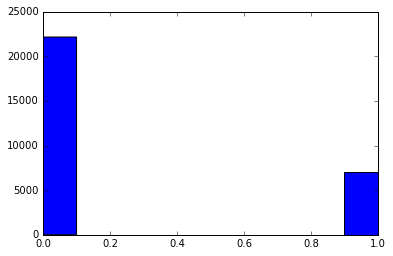

In [27]:
plt.hist(labels)

In [28]:
data.shape

(29234, 80)

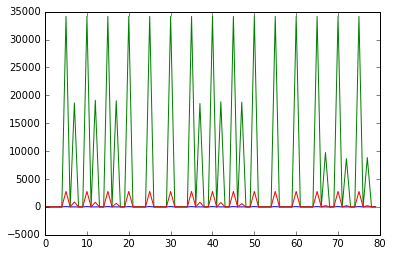

In [62]:
N=data.shape[1]
_r=range
plt.plot(_r(N),data[:,_r(N)].min(0),_r(N),data[:,_r(N)].max(0),_r(N),data[:,_r(N)].mean(0))

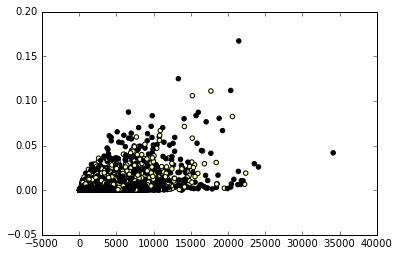

In [64]:
plt.scatter(data[:,5],data[:,62], c=labels, cmap='inferno')

## LDA

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
data2 = lda.fit(data, labels).transform(data)

/Users/megret/anaconda/envs/bnl/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [47]:
%matplotlib inline 
def view_class_hist(data, labels, bins=10):
    h0,b0=np.histogram(data[labels==0],bins=bins,normed=True)
    h1,b1=np.histogram(data[labels==1],bins=bins,normed=True)
    plt.plot(0.5*(b0[0:-1]+b0[1:]),h0, 0.5*(b1[0:-1]+b1[1:]),h1)

In [8]:
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
datap = ir.fit_transform(data2, labels)

view_class_hist(data2[:], labels)
plt.title('LDA');

ValueError: X should be a 1d array

In [14]:
plt.scatter(data2[:,0],data3[:,0], c=labels, cmap='inferno')
plt.title('LDA vs PCA[0]');

NameError: name 'data3' is not defined

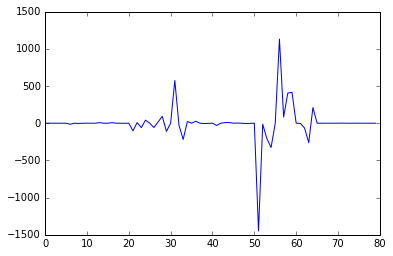

In [16]:
plt.plot(lda.scalings_);

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data3 = pca.fit(data, labels).transform(data)

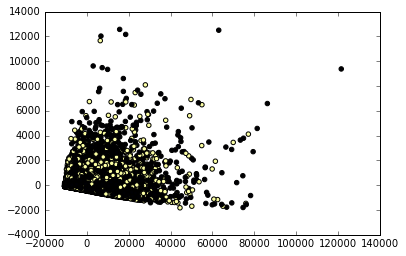

In [102]:
plt.scatter(data3[:,0],data3[:,2], c=labels, cmap='inferno')

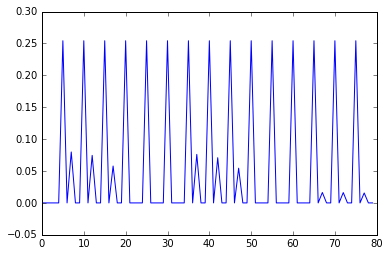

In [122]:
plt.plot(pca.components_[0,:])

In [21]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
logistic = LinearSVC(C=1e-5)
logistic.fit(data, labels)
data4 = logistic.predict(data)

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
#logistic = LogisticRegression(C=0.01)
#logistic = RidgeClassifier()
logistic = SVC( kernel='linear', probability=True)
logistic.fit(data, labels)
datalog = logistic.predictProba(data)

view_class_hist(datalog, labels, np.linspace(-1,2,20))

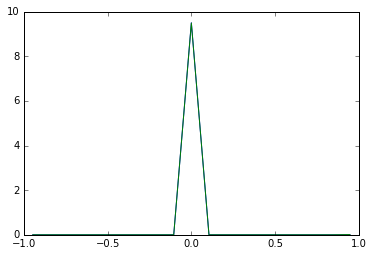

In [67]:
view_class_hist(datalog, labels, np.linspace(-1,1,20))

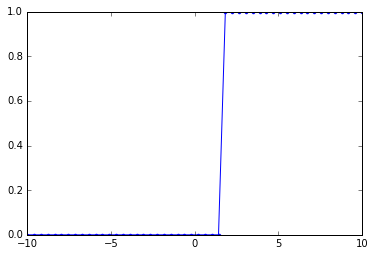

In [20]:
ss=np.linspace(-10,10)
mm=lda.means_[0,:].reshape(1,80);
aa=lda.scalings_.transpose();
xx = mm+aa * np.reshape(ss,(50,1))
plt.plot(ss,logistic.predict(xx), '.-')

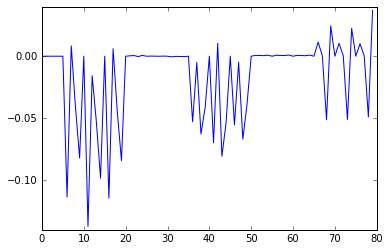

In [81]:
plt.plot(logistic.coef_[0])

(1, 80)

In [148]:
np.reshape(np.linspace(-10,10),(50,1)).shape

(50, 1)

In [154]:
mm.shape

(1, 80)